# Welcome to NameWeave - Multi Layer Perceptron Approach

Like our original <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave</a>,\
We will try to create a **Multi Layer Perceptron** to build a character level language model and predict names based on it.

To Approach this model, we will follow an approach based on the paper,\
<a href="https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf">A Neural Probabilistic Language Model</a>,\
Which is a **word level language model** but solves the similar problem of predicting words...\
This paper is 19 pages long, and we don't have time to read the entire paper,\
But I invite you to read it.

In this paper,\
They used a word vocabulary of 17000.

![Word Vocabulary](ExplanationMedia/Images/Vocabulary.png)

They then converted this vocabulary into a 30 dimensional feature space

![Vocabulary to Feature Space](ExplanationMedia/Images/VocabularytoFeatureSpace.png)

This is a very small space for a very large dataset.

The approach of this paper is also very similar because,\
They used a **multilayer neural network** to **predict the next word given the previous ones**,\
& they **maximize the log-likelihood** of the training data or a regularized criterion.

#### Why does this approach work? Let's take a concrete example

We have a phrase: *A dog was running in a room*, *The cat is walking in the bedroom*

During the training of the network, the words move around to a similar corner of the space based on their features\
So, even if the model goes *out of distribution* during test, making predictions,\
The similar words which have never occured before may occur here.

Resulting in the phrase: *A dog is walking in a bedroom*, *The cat is running in a room*

If we knew that dog and cat played similar roles (semantically and syntactically), and similarly for (the,a), (bedroom,room), (is,was), we could naturally transfer probability mass.

Let's now look at the Neural Network for this Approach

![A Neural Probabilistic Language Model - Neural Network](https://miro.medium.com/v2/resize:fit:1200/1*EqKiy4-6tuLSoPP_kub33Q.png)

In this network,\
They are taking *3 previous words* and are trying to *predict the 4-th word in a sequence*.

Now because they had the vocabulary of 17000 words (**'w'**),\
These previous words are the indexes ranging from 0-16999.

There is also a lookup-table which they call **'C'** \
This is their lookup-embedding-matrix, which is shared among all the words\
This C is a matrix of say 17000x30. (So, number of words in vocabulary by number of dimensions in the feature space).

So what this is essentially doing is,\
They are trying to pick out the row based on the index of the word from vocabulary\
And the row represents the 1x30 vector of the word's embedding.\
So they are using the same matrix over and over to look for their own vector of embedding.

So, because they are taking *3 previous words*, and each vector uses 1x30 dimensions,\
They have 3x30 dimensions making up 90 dimensions in total.

Next up is the hidden layer (tanh non-linearity layer).\
This is layer has the *hyper-parameter* (*hyper-parameter* is a parameter of the neural network, that is the designer' choice of the neural network).\
So, this layer's size can be as large as we'd like or as we'd like.\
So, we are going to go over multiple choices, and we are going to evaluage how good they work.\
Note: This layer will be fully connected to all the vector embeddings of the previous layer (90 dimensions).

Next, they have a output layer of logits (you can refer to the original <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave</a>  for reference).\
Now, because they had a vocabulary of **17000 words**, this layer has **17000 neurons** which is **fully connected to the hidden layer**.\
Resulting in the *maximum computation between the hidden layer and output layer*.

This output layer is then having a softmax activation layer, which exponentiates the logits and normalized to sum to 1.\
Which results in a nice probability distribution for the next *4-th word in a sequence*.

<hr>

During training we have the label (identity of the next word in a sequence).
That word's index is used to choose the probability of that word,\
And then they maximize the probability of that word, with respect to the parameters of this neural network.

<hr>

Parameters:
1. The *weights and biases* of the *output layer*
2. The *weights and biases* of the *hidden layer*
3. The *embedding look-up table 'C'*

So, Let's implement our own neural network, based on the above approach.

# Installing Dependencies

In [1]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib

# Importing Libraries

In [2]:
import random
import torch
import torch.nn.functional as F # This is required for one-hot encoding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\avhis\AppData\Local\Temp\ipykernel_11248\3959944622.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading Dataset

Once again, you can refer to the original <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave</a> for reference, as to why we chose to load the dataset in the following way...

In [3]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [4]:
words = [word.lower() for word in words]

In [5]:
len(words)

53982

# Building Vocabulary

In [6]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Building Dataset for Neural Network

Now, we can't just feed in names to our Neural Network.\
Rather, we need to build a dataset which will be able to feed into our neural network.

Let's visualize how we are going to feed in to the neural network first...

![Multi Layer Perceptron Approach](ExplanationMedia/Images/NameWeaveMultiLayerPerceptronApproach.png)

Let's now try to make this dataset...

Remeber, this is **not bigram anymore**.

In [7]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
inputBlockSize = 3

# We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
inputs , outputs = [], []

# We run a loop for each word in the original dataset
for word in words[:5]:
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * inputBlockSize # This is also known as the context of the network
    # We print each word
    print("Name:", word)
    # We run another loop for each word's character, here word also needs the ending token '.'
    for character in word + '.':
        # We take out the index from our look-up table
        index = stoi[character]
        # We append the input with our block
        inputs.append(block)
        # We append the output label with out index of the character
        outputs.append([index])
        # We can check our inputs and thier corresponsing outputs
        print(''.join(itos[i] for i in block), '--->', itos[index])
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
# We also convert these inputs and outputs to tensors for neural network processing
inputs = torch.tensor(inputs)
outputs = torch.tensor(outputs)

Name: aaban
... ---> a
..a ---> a
.aa ---> b
aab ---> a
aba ---> n
ban ---> .
Name: aabharan
... ---> a
..a ---> a
.aa ---> b
aab ---> h
abh ---> a
bha ---> r
har ---> a
ara ---> n
ran ---> .
Name: aabhas
... ---> a
..a ---> a
.aa ---> b
aab ---> h
abh ---> a
bha ---> s
has ---> .
Name: aabhat
... ---> a
..a ---> a
.aa ---> b
aab ---> h
abh ---> a
bha ---> t
hat ---> .
Name: aabheer
... ---> a
..a ---> a
.aa ---> b
aab ---> h
abh ---> e
bhe ---> e
hee ---> r
eer ---> .


In [8]:
# We can now check the shape of inputs and outputs and their corresponding datatypes
print("Inputs Shape:",inputs.shape,", Datatype:",inputs.dtype)
print("Outputs Shape:",outputs.shape,", Datatype:",outputs.dtype)

Inputs Shape: torch.Size([37, 3]) , Datatype: torch.int64
Outputs Shape: torch.Size([37, 1]) , Datatype: torch.int64


In [9]:
# We can also check how the inputs look like
print(inputs)

tensor([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1,  1],
        [ 1,  1,  2],
        [ 1,  2,  1],
        [ 2,  1, 14],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1,  1],
        [ 1,  1,  2],
        [ 1,  2,  8],
        [ 2,  8,  1],
        [ 8,  1, 18],
        [ 1, 18,  1],
        [18,  1, 14],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1,  1],
        [ 1,  1,  2],
        [ 1,  2,  8],
        [ 2,  8,  1],
        [ 8,  1, 19],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1,  1],
        [ 1,  1,  2],
        [ 1,  2,  8],
        [ 2,  8,  1],
        [ 8,  1, 20],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1,  1],
        [ 1,  1,  2],
        [ 1,  2,  8],
        [ 2,  8,  5],
        [ 8,  5,  5],
        [ 5,  5, 18]])


In [10]:
# We can also check how the outputs look like
print(outputs)

tensor([[ 1],
        [ 1],
        [ 2],
        [ 1],
        [14],
        [ 0],
        [ 1],
        [ 1],
        [ 2],
        [ 8],
        [ 1],
        [18],
        [ 1],
        [14],
        [ 0],
        [ 1],
        [ 1],
        [ 2],
        [ 8],
        [ 1],
        [19],
        [ 0],
        [ 1],
        [ 1],
        [ 2],
        [ 8],
        [ 1],
        [20],
        [ 0],
        [ 1],
        [ 1],
        [ 2],
        [ 8],
        [ 5],
        [ 5],
        [18],
        [ 0]])


In [11]:
# We want our outputs to be single elements in a list and not add another dimension to the list
# So we use a flatten method available in PyTorch to flatten these outputs
outputs = torch.flatten(outputs)

In [12]:
print(outputs)

tensor([ 1,  1,  2,  1, 14,  0,  1,  1,  2,  8,  1, 18,  1, 14,  0,  1,  1,  2,
         8,  1, 19,  0,  1,  1,  2,  8,  1, 20,  0,  1,  1,  2,  8,  5,  5, 18,
         0])


Now that we have our inputs and outputs configured, let's build our **embeddingLookUpMatrix 'C'**

# Building Embedding Look-up Matrix

In the paper the researchers had a big vocabulary of 17000 words,\
They used a very small 30 dimensional feature space.

Because we have a vocabulary of only 27 characters,\
Let's use a very small 2 dimensional feature space for our embedding look-up matrix.

In [13]:
# We decide to build a embeddingLookUpMatrix with 27x2 because we have a vocabulary of 27 characters and we want to fit them in a 2 dimensional space
# In the beginning we initialize it randomly
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength))
# So each one of our 27 characters will have a 2 dimensional embedding
print(embeddingLookUpMatrix)

tensor([[-0.3732, -0.2275],
        [-1.7182, -0.8157],
        [-1.1759, -1.5987],
        [-0.3984,  0.0547],
        [ 0.1003, -0.8822],
        [-2.1286, -1.6474],
        [-0.5959,  0.3235],
        [ 0.5287, -0.4012],
        [ 0.5799, -0.7293],
        [-1.4172, -2.0226],
        [-0.7001,  0.6551],
        [ 0.3579, -0.7145],
        [ 0.8300, -1.0691],
        [ 1.6646, -0.9261],
        [ 0.0049,  0.9844],
        [ 0.8385, -1.9852],
        [ 0.7729,  0.5822],
        [ 0.8481,  0.7299],
        [ 0.9389,  0.7735],
        [ 0.2951, -1.8969],
        [-0.6994,  0.2413],
        [-0.7727, -0.5433],
        [ 1.0702,  0.7694],
        [-1.2376, -0.0611],
        [ 0.2379, -0.9606],
        [ 0.2195, -0.5485],
        [-0.2583, -0.4831]])


Now that we have a embedding-look-up matrix,

For example,

We can easily do:
```python
embeddingLookUpMatrix[6]
```

To get the embedding:
```python
tensor([-0.2483, -0.3909])
```

But there is a more similar way to do the exact same thing based on one-hot encoding....

We can do:
```python
F.one_hot(torch.tensor(6), num_classes=27)
```

To get the one-hot embedding
```python
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
```

Then convert this to float and multiply it with our original *embeddingLookUpMatrix*:
```python
F.one_hot(torch.tensor(6), num_classes=27).float() @ embeddingLookUpMatrix
```

Which results in:
```python
tensor([-0.2483, -0.3909])
```

This works because of the property of matrix multiplication,

The 0's in our one-hot encoded vector discards all the zeros,\
And only multiplies the 1 to the corresponding column of the embeddingLookUpMatrix.

So we can consider this matrix multiplication to be the first layer of our neural network,\
Giving us our corresponding embedding for the index. *(1x2 embedding vector for our case)*

But we will simply index into our look-up table and discard the way of one-hot encoding for the time being

But, now that we know that we want to index into our look-up embedding matrix,\
How do we do that simultaneously for all the inputs?

PyTorch has got you covered.

In PyTorch we can, very flexibly pick out rows...

For example,\
We can do indexing with lists of indexes:
```python
embeddingLookUpMatrix[[1,2,3]]
```

Which gives out the rows of the corresponding indexes:
```python
tensor([[ 0.2118,  1.0454],
        [ 0.1876,  0.8921],
        [ 0.9759, -0.2606]])
```

We can also do:
```python
embeddingLookUpMatrix[torch.tensor([1,2,3])]
```

Which gives out the rows of the corresponding indexes:
```python
tensor([[ 0.2118,  1.0454],
        [ 0.1876,  0.8921],
        [ 0.9759, -0.2606]])
```

We can similarly pick out the same rows again and again:
```python
embeddingLookUpMatrix[[1,2,3,3,3,3]]
```

Which gives us the same row again and again:
```python
tensor([[ 0.2118,  1.0454],
        [ 0.1876,  0.8921],
        [ 0.9759, -0.2606],
        [ 0.9759, -0.2606],
        [ 0.9759, -0.266],
        [ 0.9759, -0.2606]])
```

Lastly, the magic happens when we try to do the same with multi dimensional lists as well:
```python
embeddingLookUpMatrix[[1, 0], [1, 1]]
```

Which results in:
```python
tensor([ 1.0454, -0.9078])
```

In [14]:
# So we can now easily do
embeddingLookUpMatrix[inputs]

tensor([[[-0.3732, -0.2275],
         [-0.3732, -0.2275],
         [-0.3732, -0.2275]],

        [[-0.3732, -0.2275],
         [-0.3732, -0.2275],
         [-1.7182, -0.8157]],

        [[-0.3732, -0.2275],
         [-1.7182, -0.8157],
         [-1.7182, -0.8157]],

        [[-1.7182, -0.8157],
         [-1.7182, -0.8157],
         [-1.1759, -1.5987]],

        [[-1.7182, -0.8157],
         [-1.1759, -1.5987],
         [-1.7182, -0.8157]],

        [[-1.1759, -1.5987],
         [-1.7182, -0.8157],
         [ 0.0049,  0.9844]],

        [[-0.3732, -0.2275],
         [-0.3732, -0.2275],
         [-0.3732, -0.2275]],

        [[-0.3732, -0.2275],
         [-0.3732, -0.2275],
         [-1.7182, -0.8157]],

        [[-0.3732, -0.2275],
         [-1.7182, -0.8157],
         [-1.7182, -0.8157]],

        [[-1.7182, -0.8157],
         [-1.7182, -0.8157],
         [-1.1759, -1.5987]],

        [[-1.7182, -0.8157],
         [-1.1759, -1.5987],
         [ 0.5799, -0.7293]],

        [[-1.1759, -1

In [15]:
# We can also check the shape of this
embeddingLookUpMatrix[inputs].shape

torch.Size([37, 3, 2])

We see that the size of this index is the shape of the original size of the dataset with a 2-dimensional embedding vector space

So if we do:
```python
# Input of 5th block and 3rd index of the block
inputs[5,2]
```

It gives us:
```python
tensor(14)
```

We can look that vector up by doing:
```python
embeddingLookUpMatrix[inputs][5,2]
```

Which gives us the corresponding vector of the item specified:
```python
tensor([ 1.7724, -0.9331])
```

We can verify the same by doing:
```python
embeddingLookUpMatrix[14]
```

Gives the same output:
```python
tensor([ 1.7724, -0.9331])```


In [16]:
# So we can now define our embedding into a variable
embedding = embeddingLookUpMatrix[inputs]

# Constructing Hidden Layer

Let's understand what we will initially have in the hidden layer.

1. The hidden layer will have it's own weights & biases
2. The hidden layer will have it's own neurons which will act as a hyper-parameter to set the number of neurons we want in this layer

So let's initialize weights and biases for now...

Note: The size of the weights will be based on the block size of the inputs and its corresponding vector embedding.\
Thus,

$$\text{Hidden Layer Size} = [(\text{Block Size} * \text{Vector Embedding Dimensions}), \text{Number of Neurons(Hyperparameter)}]$$

In [17]:
# We can initialize the number of neurons we want in the hidden layer
numberOfHiddenLayerNeurons = 100
# Then we can randomly initialize the weights of the hidden layer
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons)
# Then we can initialize the corresponding biases as well
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons)

In [18]:
# We can check the shapes of our hidden layer weights and hidden layer biases
print("Shape of Weights of Hidden Layer:", weightsOfHiddenLayer.shape)
print("Shape of Biases of Hidden Layer:", biasesOfHiddenLayer.shape)

Shape of Weights of Hidden Layer: torch.Size([6, 100])
Shape of Biases of Hidden Layer: torch.Size([100])


Now that we have the weights and biases initialized for our hidden layer.

By convention we would like to do something like:
$$\text{Layer Computation} = \text{Embeddings} * \text{Weights} + \text{Biases}$$

But for our case:

Embeddings are in the shape of the [number of blocks in all the names, block size, vector dimension size]\
for example, [37, 3, 2]\
& Weights are in the shape of [(block size * vector dimension size), number of neurons (hyperparameter)]\
for example, [6, 100]

And thus, we cannot just simply multiply these matrices

There are a numerous ways to do this,\
Either we can convert [37, 3, 2] ---> [37, 6]\
Or we can convert [6, 100] ---> [3, 2, 100]

We will stick with the first one, because it is fairly simpler and would reduce the complexity to understand the problem.

I invite you to also look into the documentation of <a href="https://pytorch.org/docs/stable/index.html">PyTorch</a>.

According to the official documentation,

**TORCH.CAT**
Concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be empty.

```python
torch.cat(tensors, dim=0, *, out=None) → Tensor
```

Parameters:
- tensors (sequence of Tensors) – any python sequence of tensors of the same type. Non-empty tensors provided must have the same shape, except in the cat dimension.
- dim (int, optional) – the dimension over which the tensors are concatenated

Keyword Arguments:
- out (Tensor, optional) – the output tensor.

Example:
```python
>>> x = torch.randn(2, 3)
>>> x
tensor([[ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497]])
>>> torch.cat((x, x, x), 0)
tensor([[ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497]])
>>> torch.cat((x, x, x), 1)
tensor([[ 0.6580, -1.0969, -0.4614,  0.6580, -1.0969, -0.4614,  0.6580,
         -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497, -0.1034, -0.5790,  0.1497, -0.1034,
         -0.5790,  0.1497]])
```

So we can do:
```python
# Pickout the Embedding along the dimension 0, 1 & 2 and concatenate them along dimension 1
# Each embedding[:, n, :] gives us the 3x2 embeddings
torch.cat([embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :]], dim=1)
```

And its shape turns out to be:
```python
torch.Size([37, 6])
```

But this is kind of ugly and we have another method...

**TORCH.UNBIND**
Removes a tensor dimension.

Returns a tuple of all slices along a given dimension, already without it.

```python
torch.unbind(input, dim=0) → seq
```
Parameters:
- input (Tensor) – the tensor to unbind
- dim (int) – dimension to remove

Example:
```python
>>> torch.unbind(torch.tensor([[1, 2, 3],
>>>                            [4, 5, 6],
>>>                            [7, 8, 9]]))
(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))
```

So now we can do:
```python
torch.cat(torch.unbind(embedding, dim=1), dim=1)
```

Whose shape also turns out to be:
```python
torch.Size([37, 6])
```

We have a third way of doing the same thing.

Its called:\
**TORCH.TENSOR.VIEW**

Which gives me the paternity to explain some of the features of the internals of the PyTorch Library.

We have an interesting blog post <a href="http://blog.ezyang.com/2019/05/pytorch-internals/">here</a> by Edward Z. Yang which you can go through to understand more about this.

To explain *TORCH.TENSOR.VIEW*.\
Let's take an example and explain each step one by one...

For example,\
If we do:
```python
torch.arange(0,18)
```

It gives us:
```python
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
```

This can also be viewed as:
```python
torch.arange(0,18).view(9,2)
```

Which gives us:
```python
tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
```

This can also be written as:
```python
torch.arange(0,18).view(3,3,2)
```

Which gives us:
```python
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])
```

So,\
If we have an embedding of size say: [37, 3, 2]\
We can essentially do:
```python
embedding.view(37,6)
```

We can also verify the result to be the same by doing
```python
embedding.view(37,6) == torch.cat(torch.unbind(embedding, dim=1), dim=1)
```

Resulting in all True values

So, to get the *hidden-states*, we can simply run:

```python
embedding.view(37,6)
```

to get all the hidden layer states as:

```python
hiddenLayerStates = embedding.view(37,6) @ weightsOfHiddenLayer + biasesOfHiddenLayer
```

<hr>

Before we use this, you see how we are using 37 and 6 as a number which is hard-coded and does not make our model very flexible?\
Let's fix it by using *-1* instead of *37* to specify that it should take all the inputs, and use *inputBlockSize\*embeddingFeatureSpaceLength* instead of *6*.

<hr>

Also, remembering our original multi-layer perceptron approach, we had something called tanh() non-linearity.

So, instead we would want to know what tanh() is?

So **what is tanh()**?

In order to answer that we have to understand a few more things,

In mathematics, the trigonometric functions are real functions which relate an angle of a right-angled triangle to ratios of two side lengths.
![Trigonometry](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Sinus_und_Kosinus_am_Einheitskreis_1.svg/250px-Sinus_und_Kosinus_am_Einheitskreis_1.svg.png)

In mathematics, hyperbolic functions are analogues of the ordinary trigonometric functions, but defined using the hyperbola rather than the circle.
![Hyperbola v/s Parabola](ExplanationMedia/Images/Hyperbola-vs-Parabola.png)

Here are some of the most used hyperbolic functions:
![sinhcoshtanh](https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Sinh_cosh_tanh.svg/300px-Sinh_cosh_tanh.svg.png)

So to answer the question,\
**tanh() is a hyperbolic function**, or a non-linearity we use to get a number between **-1 and 1** and ranges between $$-\infty\text{ and }\infty$$

This is the formula for tanh():\
$$\tanh x = \frac{\sinh x}{\cosh x} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}$$

![tanh](https://miro.medium.com/v2/resize:fit:443/1*WeuJzmlt3iNVWsUsvf24Eg.png)

So, we can now do:
```python
hiddenLayerStates = torch.tanh(embedding.view(37,6) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
```

In [19]:
# So putting all the above things we learnt together, we get
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
print(hiddenLayerStates)

tensor([[-0.9746,  0.5218,  0.7038,  ...,  0.5388,  0.7837,  0.3920],
        [-0.8478,  0.8180,  0.7753,  ...,  0.7804,  0.9930,  0.9403],
        [-1.0000,  0.9342,  0.9968,  ...,  0.9875,  0.9945, -0.2034],
        ...,
        [ 0.9890,  0.7714, -0.9353,  ..., -0.9566,  1.0000,  0.5880],
        [-1.0000, -0.2557,  0.9998,  ...,  0.5930,  0.9989, -0.3323],
        [-1.0000,  0.9857,  0.9425,  ...,  0.9050,  0.9418, -1.0000]])


In [20]:
# Let's see what the shape of the hidden layer states look like
print(hiddenLayerStates.shape)

torch.Size([37, 100])


Keep in mind that we need to be careful with the broadcasting rules of the '+' of:
```python
hiddenLayerStates = torch.tanh(embedding.view(37,6) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
```

I will move on to the next section, but to check the broadcasting rules you can refer to <a href="https://pytorch.org/docs/stable/notes/broadcasting.html">original documentation</a> or refer to my <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave Notebook</a> for a more simpler explanation.

So let's create our final layer next...

# Constructing Final Layer

Looking at the shape that we have right now :

```python
torch.Size([37, 100])
```

We see that we have a *100* neurons, taking *37* inputs...

We understand that each of these neurons would be the inputs to our final layer,\
Thus, we have to take a layer where it takes *100* inputs and produces the output of *27*.

Why **27**?

Because, we would be interested in the index of the output now.

So we will do:
```python
# We can initialize the number of neurons we have in the final layer
numberOfFinalLayerOutputs = 27
# Then we can randomly initialize the weights of the final layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs)
# Then we can initialize the corresponding biases as well
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs)
```

Therefore,\
The **logits** our final layer will produce would be:
$$\text{Logits} = \text{hiddenLayerStates} * \text{weightsOfFinalLayer} + \text{biasesOfFinalLayer}$$

In [21]:
# Let's construct our final layer
# We can initialize the number of neurons we have in the final layer
numberOfFinalLayerOutputs = 27
# Then we can randomly initialize the weights of the final layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs)
# Then we can initialize the corresponding biases as well
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs)

In [22]:
# Let's compute logits now
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer

In [23]:
# Let's check the output
print(logits)

tensor([[-4.4356e+00, -8.8625e+00, -6.4110e+00,  3.1217e+00, -2.3895e-01,
         -9.1472e+00,  3.5807e+00,  6.4967e+00, -1.9470e+01,  1.5936e+00,
          1.2955e+00,  5.4860e+00,  6.1289e+00, -3.6768e+00, -8.2575e+00,
         -6.8105e+00,  4.4014e+00, -6.6630e+00,  6.3047e+00,  4.2948e+00,
          3.7352e+00,  8.3515e+00, -1.2195e+01,  4.6262e+00, -6.4790e+00,
          7.4604e+00, -2.3536e+00],
        [ 2.3476e-01, -8.9568e+00, -5.2255e+00,  6.9277e+00, -4.9331e+00,
         -1.0707e+01, -3.5129e+00,  1.0341e+01, -1.0205e+01,  1.9994e+00,
          2.7964e-01,  8.9195e+00,  1.9596e+00, -1.1375e+01, -5.5082e+00,
          1.6570e-01,  7.1465e+00, -8.9007e+00, -2.8143e+00,  9.6585e+00,
          3.7122e+00,  1.8932e+01, -2.9878e+01,  1.2045e+01, -5.9551e+00,
          1.1613e+01, -9.0741e+00],
        [-5.5437e+00, -6.9723e+00, -4.4161e-01,  5.3509e+00, -4.4173e+00,
         -1.7688e+01,  6.3378e+00,  1.0275e+01, -2.4718e+01,  1.0289e+00,
         -2.9554e+00,  9.5491e-01,  7.76

In [24]:
#Let's check the shape as well
print(logits.shape)

torch.Size([37, 27])


So, we want to do exactly now what we did in our previous <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave Notebook</a>.\
We want to:
1. Take the logits
2. Exponentiate them
3. Normalize them into a probability that sum to 1

In [25]:
# So let's get our probabilities back
# Calculating counts from logits
counts = logits.exp()
# Normalizing counts to probabilities that sum to 1
probabilities = counts / counts.sum(1, keepdims=True)

In [26]:
# Let's see the probabilities in action
print(probabilities)

tensor([[1.4358e-06, 1.7160e-08, 1.9915e-07, 2.7491e-03, 9.5430e-05, 1.2909e-08,
         4.3505e-03, 8.0338e-02, 4.2430e-13, 5.9642e-04, 4.4268e-04, 2.9241e-02,
         5.5615e-02, 3.0666e-06, 3.1424e-08, 1.3357e-07, 9.8850e-03, 1.5480e-07,
         6.6309e-02, 8.8849e-03, 5.0772e-03, 5.1343e-01, 6.1277e-10, 1.2376e-02,
         1.8606e-07, 2.1060e-01, 1.1516e-05],
        [7.5674e-09, 7.7109e-13, 3.2179e-11, 6.1043e-06, 4.3111e-11, 1.3392e-13,
         1.7839e-10, 1.8536e-04, 2.2136e-13, 4.4187e-08, 7.9148e-09, 4.4736e-05,
         4.2465e-08, 6.8674e-14, 2.4256e-11, 7.0624e-09, 7.5976e-06, 8.1561e-13,
         3.5870e-10, 9.3679e-05, 2.4501e-07, 9.9798e-01, 6.3286e-22, 1.0183e-03,
         1.5513e-11, 6.6168e-04, 6.8573e-13],
        [1.4303e-10, 3.4277e-11, 2.3510e-08, 7.7077e-06, 4.4119e-10, 7.6049e-16,
         2.0679e-05, 1.0604e-03, 6.7308e-19, 1.0230e-07, 1.9033e-09, 9.5007e-08,
         8.5972e-05, 2.1543e-11, 9.3168e-12, 7.9284e-08, 1.8930e-05, 4.9287e-08,
         5.5779e-

Now that we have our probabilities,\
We also want to:
1. Calculate Loss
2. Tune the particular weights depending on the gradients

So just like our older <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave Notebook</a>, we will calculate loss such that,
1. We will take the log likelihood of the probabilities
2. Take the average of the log likelihood
3. Convert it to negetive average log likelihood

In [27]:
# Let's calculate our own average negetive log likelihood straight from this tensor
# This is the vectorized form of that expression
loss = -probabilities[torch.arange(len(inputs)), outputs].log().mean()
print(loss)

tensor(20.5695)


Let's make our code a little more respectable...

What is **entropy**?

Entropy is the measurement of disorder or impurities in the information processed in machine learning.

$$ H(X) = -\sum_{x \in \mathcal{X}} p(x) \log p(x) $$

**When entropy becomes 0, then the dataset has no impurity.**

![LowHighEntropy](https://static.javatpoint.com/tutorial/machine-learning/images/entropy-in-machine-learning3.png)

What is the **Information Gain in Entropy**?

Information gain is defined as the pattern observed in the dataset by calculating the reduction in entropy or surprise by splitting a dataset according to a given value of a random variable.

$$ \text{Information Gain} = 1-\text{Entropy} $$

![LowHighInformationGain](https://miro.medium.com/v2/resize:fit:1400/1*DsjX_bHYWn21Z0VIPjxnbw.png)

What is **Cross-Entropy**?

Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events.

What is **Cross-Entropy Loss**?

Cross-entropy loss refers to the contrast between two random variables. It measures the variables to extract the difference in the information they contain, showcasing the results.

So,\
We now understand that our lines of code:
```python
# Calculating counts from logits
counts = logits.exp()
# Normalizing counts to probabilities that sum to 1
probabilities = counts / counts.sum(1, keepdims=True)
# Calculating the negetive average log likelihood as loss
loss = -probabilities[torch.arange(len(inputs)), outputs].log().mean()
```

Can now be replaced by a ready-made function:
```python
loss = F.cross_entropy(logits, outputs)
```

Since we are doing classification...

In [28]:
# Calculating the negetive average log likelihood as loss (cross entropy loss)
loss = F.cross_entropy(logits, outputs)
# We get the same loss now
print(loss)

tensor(20.5695)


Now, why are we using *F.cross_entropy()* might be the next question coming to your mind...

There are a number of reasons, as to why,
1. Its efficient and does not require to use new memory
2. We practically don't use the three lines of code

Now you might be wondering why my last point is valid.\
Let me explain...

Suppose we write the same code:
```python
#Defining logits (example)
logits = torch.tensor([-100, -3, 0, 100])
# Calculating counts from logits
counts = logits.exp()
# Normalizing counts to probabilities that sum to 1
probabilities = counts / counts.sum(1, keepdims=True)
# Calculating the negetive average log likelihood as loss
loss = -probabilities[torch.arange(len(inputs)), outputs].log().mean()
```

Even if the code seems simple, we run into problems...\
Because when we represent counts by performing an exponential function,\
Any large negetive number works fine(it represents a very tiny number),\
But the moment we associate a very positive number along with it(it tries to represent a very large number) and it goes out of memory and count turns out to be inifinity and probabilities remain undefined as well.

So summarising the reasons:
1. The forward pass would be much more efficient
2. The backward pass would be much more efficient
3. The calculations would be mathematically well behaved

##### Now that we have all the layers, let's put all the parameters in a single variable to access all of them way faster

Let's recall what those were:
1. The *weights and biases* of the *output layer*
2. The *weights and biases* of the *hidden layer*
3. The *embedding look-up table 'C'*

In [29]:
# Let's define our parameters variable
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
print(parameters)

[tensor([[-0.3732, -0.2275],
        [-1.7182, -0.8157],
        [-1.1759, -1.5987],
        [-0.3984,  0.0547],
        [ 0.1003, -0.8822],
        [-2.1286, -1.6474],
        [-0.5959,  0.3235],
        [ 0.5287, -0.4012],
        [ 0.5799, -0.7293],
        [-1.4172, -2.0226],
        [-0.7001,  0.6551],
        [ 0.3579, -0.7145],
        [ 0.8300, -1.0691],
        [ 1.6646, -0.9261],
        [ 0.0049,  0.9844],
        [ 0.8385, -1.9852],
        [ 0.7729,  0.5822],
        [ 0.8481,  0.7299],
        [ 0.9389,  0.7735],
        [ 0.2951, -1.8969],
        [-0.6994,  0.2413],
        [-0.7727, -0.5433],
        [ 1.0702,  0.7694],
        [-1.2376, -0.0611],
        [ 0.2379, -0.9606],
        [ 0.2195, -0.5485],
        [-0.2583, -0.4831]]), tensor([[ 0.3253, -1.7963,  0.9002, -0.0506, -1.0483,  0.0677, -0.2041, -0.8192,
          0.5607, -0.2761, -0.1341,  1.1116,  1.0652, -2.0130, -0.6983, -0.5113,
         -1.4599, -0.4864, -1.1663, -0.7709,  0.7650,  0.2706, -0.0645, -0.1961

In [30]:
# We must set requires_grad to True in all the parameters to avoid any errors in the future
for parameter in parameters:
    parameter.requires_grad = True

Let's put everything we have together for now with a respectable generator so that we all get the same output

In [31]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
for parameter in parameters:
    parameter.requires_grad = True

In [32]:
# Let's check how many parameters we have
sum(parameter.nelement() for parameter in parameters)

3481

Let's understand how neural network will train itself with forward pass, backward pass and updatation now...

Now that we have trained two neural networks already...

We can safely say that they work in the sequence:
1. Forward Pass - Makes calculations and calculates loss
2. Backward Pass - Resets all the gradients and back propagtes through the network
3. Data Updation - Updates the data for all the parameters in the opposite direction of the gradient depending on the learning rate

In [33]:
# Forward Pass
embedding = embeddingLookUpMatrix[inputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, outputs)
print("Loss:", loss)

# Backward Pass
for parameter in parameters:
    parameter.grad = None
loss.backward()

# Update Weights
learning_rate = 0.1
for parameter in parameters:
    parameter.data += -learning_rate * parameter.grad

Loss: tensor(17.2358, grad_fn=<NllLossBackward0>)


So we can take it in a loop to train the model over and over...

In [34]:
# We define the number of epochs
epochs = 10
for _ in range(epochs):
    # Forward Pass
    embedding = embeddingLookUpMatrix[inputs]
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs)
    print("Loss:", loss)
    
    # Backward Pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights
    learning_rate = 0.1
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

Loss: tensor(11.6850, grad_fn=<NllLossBackward0>)
Loss: tensor(7.4660, grad_fn=<NllLossBackward0>)
Loss: tensor(5.0195, grad_fn=<NllLossBackward0>)
Loss: tensor(4.3795, grad_fn=<NllLossBackward0>)
Loss: tensor(3.9817, grad_fn=<NllLossBackward0>)
Loss: tensor(3.6464, grad_fn=<NllLossBackward0>)
Loss: tensor(3.4343, grad_fn=<NllLossBackward0>)
Loss: tensor(3.2572, grad_fn=<NllLossBackward0>)
Loss: tensor(2.7560, grad_fn=<NllLossBackward0>)
Loss: tensor(2.4867, grad_fn=<NllLossBackward0>)


See how our loss comes down so fast...

That's because we are **overfitting** our model...

How you ask?

That's because we are considering only 5 names (37 input examples) at the moment for 3479 parameters.\
Thus, the result of fitting a very less amount of data for a very large number of parameters.

How come our loss does not come to exactly 0 then?

The answer lies within the first input example of each name...\
Remember how we are fitting:
- ... -> a (first input example of a name starting with a)
- ... -> c (first input example of a name starting with c)
- ... -> y (first input example of a name starting with y)
and so on...

So we are not completely overfitting the model, but rather we are overfitting the unique inputs for unique outputs...

So let's consider the entire dataset now and optimize the neural network...

# Optimizing Neural Network

In [35]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [36]:
words = [word.lower() for word in words]

In [37]:
print(len(words))

53982


In [38]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [39]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
inputBlockSize = 3

# We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
inputs , outputs = [], []

# We run a loop for each word in the original dataset
for word in words:
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * inputBlockSize # This is also known as the context of the network
    # We run another loop for each word's character, here word also needs the ending token '.'
    for character in word + '.':
        # We take out the index from our look-up table
        index = stoi[character]
        # We append the input with our block
        inputs.append(block)
        # We append the output label with out index of the character
        outputs.append([index])
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
# We also convert these inputs and outputs to tensors for neural network processing
inputs = torch.tensor(inputs)
outputs = torch.flatten(torch.tensor(outputs))

In [40]:
# We can now check the shape of inputs and outputs and their corresponding datatypes
print("Inputs Shape:",inputs.shape,", Datatype:",inputs.dtype)
print("Outputs Shape:",outputs.shape,", Datatype:",outputs.dtype)

Inputs Shape: torch.Size([488074, 3]) , Datatype: torch.int64
Outputs Shape: torch.Size([488074]) , Datatype: torch.int64


In [41]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [42]:
# Let's check how many parameters we have
sum(parameter.nelement() for parameter in parameters)

3481

In [43]:
# We define the number of epochs
epochs = 10
for _ in range(epochs):
    # Forward Pass
    embedding = embeddingLookUpMatrix[inputs]
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs)
    print("Loss:", loss)
    
    # Backward Pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights
    learning_rate = 0.1
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

Loss: tensor(19.4960, grad_fn=<NllLossBackward0>)
Loss: tensor(17.4382, grad_fn=<NllLossBackward0>)
Loss: tensor(15.7174, grad_fn=<NllLossBackward0>)
Loss: tensor(14.5988, grad_fn=<NllLossBackward0>)
Loss: tensor(13.6550, grad_fn=<NllLossBackward0>)
Loss: tensor(12.8257, grad_fn=<NllLossBackward0>)
Loss: tensor(12.1082, grad_fn=<NllLossBackward0>)
Loss: tensor(11.4890, grad_fn=<NllLossBackward0>)
Loss: tensor(10.9438, grad_fn=<NllLossBackward0>)
Loss: tensor(10.4558, grad_fn=<NllLossBackward0>)


See how this takes a lot more time now?

In practice, we never use the entire dataset for training in one go..

We consider small batches, what I like to call is *'mini-batches'*...

![MiniBatchesTraining](https://www.baeldung.com/wp-content/uploads/sites/4/2022/06/minibatch_gd.png)

Doing this, the quality of our gradient becomes lower, because now it is not the actual gradient direction...\
But even then,\
**It is much better to have an approximate gradient and have more steps, than it is to calculate the exact gradient and take fewer steps.**

We can define a list of random integers to index starting from 0 to the size of 0-th dimension of the inputs
We define the size to be of 5 names, which were roughly say, 37 examples for the first 5 words
```python
indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
```

We can then index into the lookup matrix to get the embeddings of only those indexes using:
```python
embeddingLookUpMatrix[inputs[indexes]]
```

In [44]:
# We define the number of epochs
epochs = 1000
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]] # Indexing into look-up table
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs[indexes]) # Indexing into labels
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

print("Minibatch Loss:", loss)

Minibatch Loss: tensor(2.2117, grad_fn=<NllLossBackward0>)


In [45]:
# Gradient of the entire training set
embedding = embeddingLookUpMatrix[inputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, outputs)
print("Loss:", loss)

Loss: tensor(2.3259, grad_fn=<NllLossBackward0>)


The problem now is...

We don't know if we are stepping too slow or too fast into the dataset...

So now the question arises is...

**How do we determine the learning rate?**

Let's experiment manually first...

# Manual Learning Rate Experimentation

### Resetting the parameters

In [46]:
# Resetting the parameters
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [47]:
# Let's check how many parameters we have
sum(parameter.nelement() for parameter in parameters)

3481

In [48]:
# We define the number of epochs
epochs = 100
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]] # Indexing into look-up table
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs[indexes]) # Indexing into labels

    print("Minibatch Loss:", loss)
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.001 # Assuming this is very low
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

Minibatch Loss: tensor(18.6522, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.9291, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.4235, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(21.0288, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.5132, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.8916, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.6657, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(22.0373, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(16.7524, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.9729, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.8925, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.8515, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.3152, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.7028, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.5437, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(16.6896, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.4077, grad_fn=

**Right now the loss is barely decreasing...**

### We reset the parameters again...

In [49]:
# Resetting the parameters
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [50]:
# We define the number of epochs
epochs = 100
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]] # Indexing into look-up table
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs[indexes]) # Indexing into labels

    print("Minibatch Loss:", loss)
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.01 # Assuming this is low
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

Minibatch Loss: tensor(22.0868, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.9440, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.5703, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.1174, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.6400, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(22.7232, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(16.6106, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.7132, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.4819, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(15.3402, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(16.3563, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.6350, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.9277, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(14.9505, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.4924, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.6699, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(15.1450, grad_fn=

**We are decreasing the loss now, but not very quickly...**

### We reset the parameters again...

In [51]:
# Resetting the parameters
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [52]:
# We define the number of epochs
epochs = 100
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]] # Indexing into look-up table
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs[indexes]) # Indexing into labels

    print("Minibatch Loss:", loss)
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 1 # Assuming this is high
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

Minibatch Loss: tensor(19.3488, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(16.5682, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(14.6362, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(11.3325, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(9.1051, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(10.0847, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(8.4405, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(7.0867, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(8.8115, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(11.1865, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(8.4249, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(8.2271, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(7.3415, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(9.0825, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(8.7848, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(9.3682, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(8.8127, grad_fn=<NllLossBac

**We are minimizing the loss but it is kind of unstable right now...**

### We reset the parameters again...

In [53]:
# Resetting the parameters
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [54]:
# We define the number of epochs
epochs = 100
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]] # Indexing into look-up table
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs[indexes]) # Indexing into labels

    print("Minibatch Loss:", loss)
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 10 # Assuming this is very high
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

Minibatch Loss: tensor(17.5197, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(58.8351, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(63.9221, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(54.7494, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(42.2917, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(59.3939, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(74.2832, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(53.8748, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(64.6195, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(93.0884, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(78.4838, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(51.2402, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(55.2153, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(58.6816, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(50.9520, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(38.5916, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(51.7255, grad_fn=

**So, now we are not minimizing the loss at all...**

### Tracking Stats

Now we can safely assume that ***learning-rate*** is somewhere **between 0.001 and 1**

We can now list out start and end with 1000 different points betweeen 0.001 and 1:
```python
torch.linspace(start=0.001, end=1, steps=1000)
```

But now that we see a small pattern that this same line can be replaced with a small mathematical expression after relating to it.

We see that we are considering the points between 0.001 and 1,\
This also evaluates to *10^-3 to 10^0*

That is because:
$$ 10^0 = 1 $$
$$ 10^{-1} = 0.1 $$
$$ 10^{-2} = 0.01 $$
and so on...

So we can replace the above code with these lines:
```python
lossExpression = torch.linspace(start=-3, end=0, steps=1000)
lossExponentExpression = 10**lossExpression
```

In [55]:
# We define a list that goes from -3 to 0 with 1000 steps
lossExpression = torch.linspace(start=-3, end=0, steps=1000)
# We do a 10^value expression on the value of the above list
lossExponentExpression = 10**lossExpression
print(lossExponentExpression)

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

#### We reset the parameters again...

In [56]:
# Resetting the parameters
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [57]:
# We define a list that goes from -3 to 0 with 1000 steps
lossExpression = torch.linspace(start=-3, end=0, steps=1000)
# We do a 10^value expression on the value of the above list
lossExponentExpression = 10**lossExpression

We will keep the steps and epoch same, to math the number of checks...

In [58]:
# We want to track the learning rates that we use in the training
learningRates = []
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 1000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]] # Indexing into look-up table
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs[indexes]) # Indexing into labels

    print("Minibatch Loss:", loss)
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = lossExponentExpression[i]
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append both the learning rates and losses that we use per iteration
    learningRates.append(lossExponentExpression[i])
    losses.append(loss.item())

Minibatch Loss: tensor(20.4912, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.4186, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.8297, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.9427, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.8288, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.8154, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.9068, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.8447, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.1165, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(21.9518, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.8166, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.4713, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.6362, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(20.2488, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(19.6756, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(17.4145, grad_fn=<NllLossBackward0>)
Minibatch Loss: tensor(18.3921, grad_fn=

Now we can plot and check the learning rates and the losses...

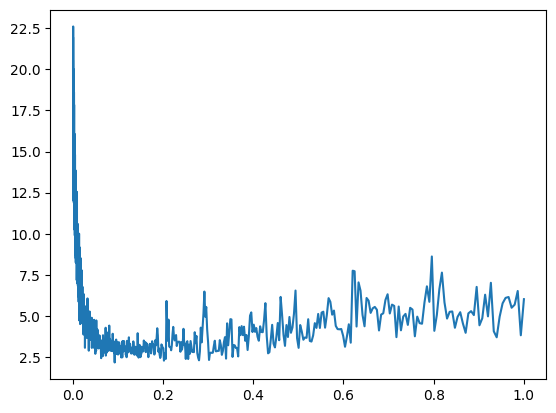

In [59]:
plt.plot(learningRates, losses)

### Deciding The Learning Rate

We see that we get a nice descent when the learning rates start at 0.001 and go till approximately 0.1...\
But generally as we decide to go up... The losses start becoming unstable...

So we can now go back to 0.01, which seems to be a fairly good learning rate...

### Understanding Learning Rate Decay

What is **learning-rate decay**?

Learning rate decay is a technique for training modern neural networks. It starts training the network with a large learning rate and then slowly reducing/decaying it until *local minima* is obtained.

![LossesonLearningRates](https://miro.medium.com/v2/resize:fit:918/0*xH_N3_XR83b9LwzI)

# Retraining Model

Now that we know what our learning rate should be...
We can go and check the model's loss and if it beats our original bigram loss from <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave</a>.

Original <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave</a> Loss:
```python
Loss: 2.2942557334899902
```

Keep in mind, that we will take *Learning Rate Decay* in mind and try to see the dent it makes...

In [60]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [61]:
words = [word.lower() for word in words]

In [62]:
print(len(words))

53982


In [63]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [64]:
# We can now check the shape of inputs and outputs and their corresponding datatypes
print("Inputs Shape:",inputs.shape,", Datatype:",inputs.dtype)
print("Outputs Shape:",outputs.shape,", Datatype:",outputs.dtype)

Inputs Shape: torch.Size([488074, 3]) , Datatype: torch.int64
Outputs Shape: torch.Size([488074]) , Datatype: torch.int64


In [65]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [66]:
# We define the number of epochs
epochs = 10000
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=inputs.shape[0], size=(37,))
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]] # Indexing into look-up table
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, outputs[indexes]) # Indexing into labels
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

print("Minibatch Loss:", loss)

Minibatch Loss: tensor(2.1826, grad_fn=<NllLossBackward0>)


See how we have already beaten the bigram loss from <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave.ipynb">NameWeave</a>

Which was:
```python
Loss: 2.2942557334899902
```

But now we have:
```python
Minibatch Loss: 2.1826
```

**Well, even if it seems like we have beaten the model...** \
**This is a fairly small model, and models can get larger and complex if we keep adding *Neurons* and *Parameters*** \
**And so we can have millions and billions of parameters,** \
**And as the capacity of the neural network grows, the model becomes more capable of overfitting the training set...**

That means if we try to sample from our model, we will only get examples based on only the training data the model was trained on...\
We won't be getting any newer data, Or rather it would be **bad** at predictions.\
In addition to that, the loss on the predicted data would be very high.

To overcome this, **we split our data into three sets**:
1. **Training Split (Roughly 80%) - Used to Optimize all the Parameters of the Model**
2. **Validation/Dev Split (Roughly 10%) - Used to Optimize all the Hyper-Parameters of the Model**
3. **Testing Split (Roughly 10%) - Used to evaluate the performance of the model at the end**

The hyper-parameters could be:-
1. The size of the hidden layer neurons
2. The size of the embeddings
3. The strength of the regularization (we are not using yet)
and so on...

We check over many different *variations* of them to test which works the best for us...

**We also tend to calculate the loss on a *test-split* very cautiously and very few times,** \
**Because, every single time we evaluate our test loss, the model learns something from the split..** \
**So, we basically end up overfitting the test-split as well** \
**Therefore, we are only allowed to test the loss on test-split very less times**

# Splitting Dataset

In [67]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [68]:
words = [word.lower() for word in words]

In [69]:
print(len(words))

53982


In [70]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We will convert our code:
```python
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
inputBlockSize = 3

# We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
inputs , outputs = [], []

# We run a loop for each word in the original dataset
for word in words[:5]:
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * inputBlockSize # This is also known as the context of the network
    # We print each word
    print("Name:", word)
    # We run another loop for each word's character, here word also needs the ending token '.'
    for character in word + '.':
        # We take out the index from our look-up table
        index = stoi[character]
        # We append the input with our block
        inputs.append(block)
        # We append the output label with out index of the character
        outputs.append([index])
        # We can check our inputs and thier corresponsing outputs
        print(''.join(itos[i] for i in block), '--->', itos[index])
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
# We also convert these inputs and outputs to tensors for neural network processing
inputs = torch.tensor(inputs)
outputs = torch.flatten(torch.tensor(outputs))
```

Into a function now...

In [71]:
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define a Block Size based on the number of characters we feed are going to feed to predict the next one
    inputBlockSize = 3
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * inputBlockSize # This is also known as the context of the network
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

In [72]:
# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)

In [73]:
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))

In [74]:
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

In [75]:
# We can check the numbers
print("Total Examples:",len(words))
print("Training Examples:",len(words[:numberOfInputs1]))
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2]))
print("Test Examples:",len(words[numberOfInputs2:]))

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


In [76]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 100
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [77]:
# We define the number of epochs
epochs = 10000
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(37,)) # Changing to Training Inputs
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]]
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes]) # Changing to Training Outputs
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

print("Minibatch Loss:", loss)

Minibatch Loss: tensor(2.4522, grad_fn=<NllLossBackward0>)


Let's evaluate the loss over the *Training-Split*...

In [78]:
# Forward Pass (Training-Split)
embedding = embeddingLookUpMatrix[trainingInputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, trainingOutputs)
print("Loss:", loss)

Loss: tensor(2.7447, grad_fn=<NllLossBackward0>)


Now we will evaluate over the *Dev-Split* or the *Validation-Split*...

In [79]:
# Forward Pass (Validation-Split)
embedding = embeddingLookUpMatrix[validationInputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, validationOutputs)
print("Loss:", loss)

Loss: tensor(2.7460, grad_fn=<NllLossBackward0>)


We see that the loss of the *Training-Split* and the *Validation-Split* are almost equal,\
That means that we are not **overfitting**, and that our model is not powerful enough to purely memorize the data.

Rather, so far we are **underfitting** the data, because, the loss of the *Training-Split* and the *Validation-Split* are roughly equal...\
That means our model is very small and we can make performance improvements by scaling up our model...

# Scaling Up Model (Increasing Complexity)

In [80]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [81]:
words = [word.lower() for word in words]

In [82]:
print(len(words))

53982


In [83]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [84]:
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define a Block Size based on the number of characters we feed are going to feed to predict the next one
    inputBlockSize = 3
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * inputBlockSize # This is also known as the context of the network
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

In [85]:
# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)

In [86]:
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))

In [87]:
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

In [88]:
# We can check the numbers
print("Total Examples:",len(words))
print("Training Examples:",len(words[:numberOfInputs1]))
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2]))
print("Test Examples:",len(words[numberOfInputs2:]))

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


In [89]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 2
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 300 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [90]:
# We define the number of epochs
epochs = 20000
for _ in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(37,)) # Changing to Training Inputs
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]]
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes]) # Changing to Training Outputs
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

print("Minibatch Loss:", loss)

Minibatch Loss: tensor(3.0100, grad_fn=<NllLossBackward0>)


In [91]:
# Forward Pass (Training-Split)
embedding = embeddingLookUpMatrix[trainingInputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, trainingOutputs)
print("Loss:", loss)

Loss: tensor(2.7526, grad_fn=<NllLossBackward0>)


In [92]:
# Forward Pass (Validation-Split)
embedding = embeddingLookUpMatrix[validationInputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, validationOutputs)
print("Loss:", loss)

Loss: tensor(2.7547, grad_fn=<NllLossBackward0>)


We see that we get a slightly lower loss that what we had before...\
But even then it does not happen too well...

One of the reasons might be is because,\
Even though we made our hidden layer much bigger, the input or the embedding layer could be a bottleneck.\
That is because we could be pushing too many characters into just 2-dimensions and the neural network could be not able to use the space effectively..

If we try to visualize our embeddings now, we would not see a pattern like we would on the *names that use vowels* because the Indian names are based more on the *syllables*...

But roughly speaking, if these were the names which used *vowels*, we would be seeing that the vowels would stack up almost forming a cluster, the token '.' treating itself separately, the character 'q' treating itself differently.\
Thus the embeddings would make sense...

Ours make sense too,\
In a different way.

### Making the embeddings bigger

In [93]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [94]:
words = [word.lower() for word in words]

In [95]:
print(len(words))

53982


In [96]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [97]:
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define a Block Size based on the number of characters we feed are going to feed to predict the next one
    inputBlockSize = 3
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * inputBlockSize # This is also known as the context of the network
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

In [98]:
# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)

In [99]:
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))

In [100]:
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

In [101]:
# We can check the numbers
print("Total Examples:",len(words))
print("Training Examples:",len(words[:numberOfInputs1]))
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2]))
print("Test Examples:",len(words[numberOfInputs2:]))

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


In [102]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [103]:
# We define a list that goes from -3 to 0 with 1000 steps
lossExpression = torch.linspace(start=-3, end=0, steps=1000)
# We do a 10^value expression on the value of the above list
lossExponentExpression = 10**lossExpression

In [104]:
# We want to track the learning rates that we use in the training
learningRates = []
# We want to track the losses that we use in the training
losses = []
# We want to track the number of iterations we use in the training
numberOfIterations = []

In [105]:
# We define the number of epochs
epochs = 50000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(37,)) # Changing to Training Inputs
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]]
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes]) # Changing to Training Outputs
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append both the learning rates and losses that we use per iteration
    numberOfIterations.append(i)
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
print("Minibatch Loss:", loss)

Minibatch Loss: tensor(2.7674, grad_fn=<NllLossBackward0>)


In [106]:
# Learning Rate Decay
# We define the number of epochs
epochs = 1000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(37,)) # Changing to Training Inputs
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]]
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes]) # Changing to Training Outputs
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.001
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append both the learning rates and losses that we use per iteration
    numberOfIterations.append(i)
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
print("Minibatch Loss:", loss)

Minibatch Loss: tensor(2.5523, grad_fn=<NllLossBackward0>)


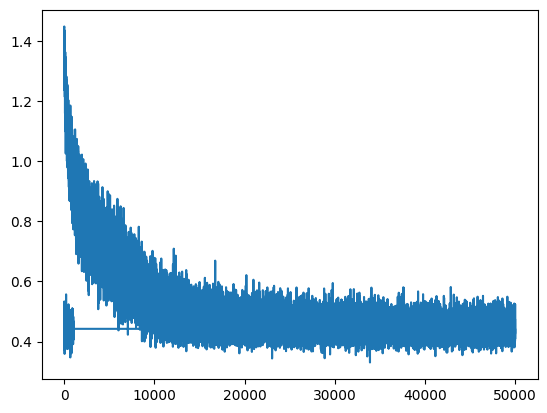

In [107]:
plt.plot(numberOfIterations, losses)

In [108]:
# Forward Pass (Training-Split)
embedding = embeddingLookUpMatrix[trainingInputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, trainingOutputs)
print("Loss:", loss)

Loss: tensor(2.7506, grad_fn=<NllLossBackward0>)


In [109]:
# Forward Pass (Validation-Split)
embedding = embeddingLookUpMatrix[validationInputs]
hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
loss = F.cross_entropy(logits, validationOutputs)
print("Loss:", loss)

Loss: tensor(2.7535, grad_fn=<NllLossBackward0>)


**As we see the Training and Validation Splits to slowly depart from each other, that means that our model is finally good enough to slightly overfit the data.**

# Final Multi-Layer Perceptron Approach Code

In [110]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [111]:
words = [word.lower() for word in words]

In [112]:
print(len(words))

53982


In [113]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [114]:
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define a Block Size based on the number of characters we feed are going to feed to predict the next one
    inputBlockSize = 3
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * inputBlockSize # This is also known as the context of the network
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

In [115]:
# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)

In [116]:
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))

In [117]:
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

In [118]:
# We can check the numbers
print("Total Examples:",len(words))
print("Training Examples:",len(words[:numberOfInputs1]))
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2]))
print("Test Examples:",len(words[numberOfInputs2:]))

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


In [119]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((len(stoi),embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((inputBlockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
numberOfFinalLayerOutputs = 27
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, numberOfFinalLayerOutputs, generator=generator)
biasesOfFinalLayer = torch.randn(numberOfFinalLayerOutputs, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [120]:
# We define a list that goes from -3 to 0 with 1000 steps
lossExpression = torch.linspace(start=-3, end=0, steps=1000)
# We do a 10^value expression on the value of the above list
lossExponentExpression = 10**lossExpression

In [121]:
# We want to track the learning rates that we use in the training
learningRates = []
# We want to track the losses that we use in the training
losses = []
# We want to track the number of iterations we use in the training
numberOfIterations = []

In [122]:
# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(37,)) # Changing to Training Inputs
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputs[indexes]]
    hiddenLayerStates = torch.tanh(embedding.view(-1, inputBlockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes]) # Changing to Training Outputs
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append both the learning rates and losses that we use per iteration
    numberOfIterations.append(i)
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
print("Minibatch Loss:", loss)

Minibatch Loss: tensor(2.7366, grad_fn=<NllLossBackward0>)


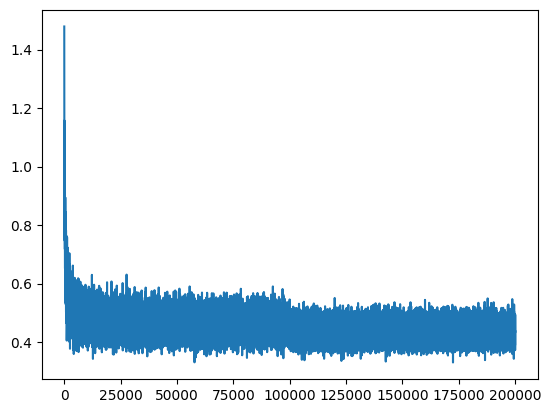

In [123]:
plt.plot(numberOfIterations, losses)

I now also invite you to beat this loss and make this model more optimized...\
Its way more fun, to learn when we take on a challenge on ourselves...

# Sampling from our model

In [124]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)

# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
inputBlockSize = 3

# We will define a generator to give the same result on your machine, as of my machine
numberOfWordsToSample = 20

# We iterate over the number of words we want to predict
for _ in range(numberOfWordsToSample):
    # We define a output list to append the next character and print it at the end
    output = []
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * inputBlockSize

    # We will now iterate over each word's characters
    while True:
        # We would create an output embedding that would be based on the block
        embedding = embeddingLookUpMatrix[torch.tensor([block])]
        # We would be doing a foward pass on the above embedding vector 
        hiddenLayerStates = torch.tanh(embedding.view(1, -1) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
        logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
        probabilities = F.softmax(logits, dim=1)
        # We can now sample the next character
        index = torch.multinomial(probabilities, num_samples=1, generator=generator).item()
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
        # We then append the sampled character to the output
        output.append(index)
        # If we hit '.' end token, we will break out from the loop
        if index == 0:
            break
    # We print generated name out
    print(''.join(itos[index] for index in output))

k.
orunyrehihaanjhiaitnth.
noh.
.
.
kahiaeineihhdmirisennaaaknaagaak.
narhrhsehieksa.
agaai.
n.
jti.
aaeavnav.
han.
kianhhonte.
h.
baktvavaa.
naj.
animevmeketonynaninhe.
aio.
aia.
yi.


As we can see that our names have started to sound a lot more name like, other than before...\
So we are definately making progress but we can improve our model by quite a bit in the next notebooks...